# Baseline Model Development

## Import packages

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
#import h5py

## Import data

### Flight Data

In [73]:
!ls /home/gridsan/mokeeffe/magnav/flight_data/

Flt1002-magnetometers.csv  Flt1002-train.h5  Flt1004-train.h5
Flt1002-magnetometers.h5   Flt1003-train.h5  Flt1005-train.h5


In [75]:
# Reading hdf files not working on Supercloud using h5py or pandas.read_hdf
# flight_data = pd.read_hdf("/home/gridsan/mokeeffe/magnav/flight_data/Flt1002-magnetometers.h5", key='df')
flight_data = pd.read_csv("/home/gridsan/mokeeffe/magnav/flight_data/Flt1002-magnetometers.csv")

In [76]:
flight_data.head()

,Unnamed: 0,tt,flux_b_t,flux_b_x,flux_b_y,flux_b_z,flux_c_t,flux_c_x,flux_c_y,flux_c_z,...,flux_d_z,mag_1_c,mag_1_dc,mag_1_igrf,mag_1_lag,mag_1_uc,mag_2_uc,mag_3_uc,mag_4_uc,mag_5_uc
0,0,45100.0,53533.107,28294.945,44045.834,11182.849,54584.776,-48636.719,-23909.552,-6496.585,...,-5872.882,53516.740,53522.679,-297.343,53519.854,53519.161,51888.734,51816.828,52644.111,53644.934
1,1,45100.1,53534.123,28489.807,43945.789,11087.419,54600.732,-48719.451,-23833.611,-6288.771,...,-5662.137,53517.734,53523.780,-296.223,53520.954,53520.123,51875.519,51836.852,52639.238,53650.004
2,2,45100.2,53535.215,28664.771,43859.696,10983.422,54615.024,-48800.914,-23747.780,-6105.427,...,-5477.210,53518.757,53524.904,-295.079,53522.078,53521.114,51858.647,51852.404,52634.938,53656.292
3,3,45100.3,53536.381,28817.314,43788.425,10875.071,54627.602,-48879.150,-23656.250,-5947.409,...,-5319.580,53519.817,53526.025,-293.939,53523.199,53522.145,51838.810,51861.915,52631.027,53662.324
4,4,45100.4,53537.604,28944.894,43732.820,10766.830,54638.511,-48952.235,-23563.447,-5815.530,...,-5189.712,53520.918,53527.123,-292.821,53524.298,53523.217,51818.311,51865.431,52627.730,53666.836


### Preprocessed Data

Let's import the preprocessed magnetometer data, to which we have applied Tolles-Lawson calibration, and corrections for diurnal and core field variations. 

In [77]:
mag_1_TL = pd.read_csv("/home/gridsan/mokeeffe/magnav/preprocessed_data/mag_1_c.csv", header=None, names=["mag_1_TL"])
mag_3_TL = pd.read_csv("/home/gridsan/mokeeffe/magnav/preprocessed_data/mag_3_c.csv", header=None, names=["mag_3_TL"])
mag_5_TL = pd.read_csv("/home/gridsan/mokeeffe/magnav/preprocessed_data/mag_5_c.csv", header=None, names=["mag_5_TL"])

In [78]:
mags_TL = pd.concat([mag_1_TL, mag_3_TL, mag_5_TL], axis=1)
mags_TL.head()

,mag_1_TL,mag_3_TL,mag_5_TL
0,-300.437677,-1033.112280,-49.709221
1,-299.428646,-1028.635159,-45.329437
2,-298.388462,-1026.268370,-39.541183
3,-297.310545,-1028.438106,-34.057425
4,-296.192719,-1034.782676,-30.108781


The min and max indices in MagNav.jl for the calibration 1 line were 12702 and 25002, respectively (note, Julia is 1 indexed and Python is 0 indexed, so we'll subtract 1). Let's plot the three calibrated magnetometers to make sure they look the same as in the first lesson notebook. Even though we just saved from a Julia array into a `.csv` file and loaded into a pandas `DataFrame` here, it's good to check that it worked. 

<Figure size 1152x864 with 0 Axes>

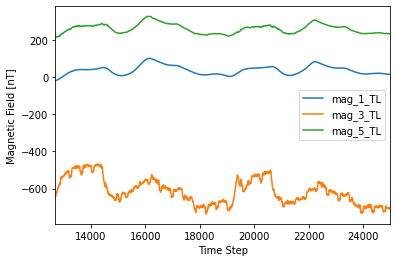

In [96]:
plt.figure(figsize=(16,12))
mags_TL[12701:25001].plot()
plt.xlabel("Time Step")
plt.ylabel("Magnetic Field [nT]")
plt.show()

## Prepare data for model development

Combine the original and processed data into a single dataframe.

In [97]:
df = pd.concat([flight_data, mags_TL], axis=1)

In [98]:
df_test = df.drop(columns=[df.columns[0], 'tt', 'mag_1_dc', 'mag_1_igrf', 'mag_1_lag', 'mag_1_uc', 'mag_2_uc', 'mag_4_uc', 'mag_5_uc', 'mag_1_TL', 'mag_5_TL'], inplace=True)
df.dtypes

flux_b_t    float64
flux_b_x    float64
flux_b_y    float64
flux_b_z    float64
flux_c_t    float64
flux_c_x    float64
flux_c_y    float64
flux_c_z    float64
flux_d_t    float64
flux_d_x    float64
flux_d_y    float64
flux_d_z    float64
mag_1_c     float64
mag_3_uc    float64
mag_3_TL    float64
dtype: object

In [99]:
target = df.pop('mag_1_c')

In [83]:
N_dev = 30000
dataset = tf.data.Dataset.from_tensor_slices((df.head(N_dev).values, target.head(N_dev).values))
input_shape = dataset.element_spec[0].shape

In [84]:
#for feat, targ in dataset.take(5):
#    print ('Features: {}, Target: {}'.format(feat, targ))

In [85]:
# TODO: normalize or standardize data

In [86]:
# TODO: train/val/test split - 60/20/20

In [87]:
train_dataset = dataset.shuffle(len(df)).batch(32)

In [88]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.Huber(),
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [89]:
model = get_compiled_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 30)                450       
_________________________________________________________________
dense_19 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 31        
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________


In [90]:
history = model.fit(train_dataset, epochs=30)

Epoch 1/30
938/938 [==============================] - 1s 1ms/step - loss: 1882.1117 - mean_squared_error: 64285160.0000 - mean_absolute_error: 1882.6112
Epoch 2/30
938/938 [==============================] - 1s 1ms/step - loss: 157.0864 - mean_squared_error: 49905.3438 - mean_absolute_error: 157.5856
Epoch 3/30
938/938 [==============================] - 1s 1ms/step - loss: 136.3768 - mean_squared_error: 33037.7344 - mean_absolute_error: 136.8760
Epoch 4/30
938/938 [==============================] - 1s 1ms/step - loss: 131.6408 - mean_squared_error: 30270.5840 - mean_absolute_error: 132.1400
Epoch 5/30
938/938 [==============================] - 1s 1ms/step - loss: 135.3891 - mean_squared_error: 31189.1465 - mean_absolute_error: 135.8884
Epoch 6/30
938/938 [==============================] - 1s 1ms/step - loss: 118.8540 - mean_squared_error: 24725.8652 - mean_absolute_error: 119.3531
Epoch 7/30
938/938 [==============================] - 1s 1ms/step - loss: 128.5721 - mean_squared_error: 27

In [91]:
predictions = pd.DataFrame(model.predict(train_dataset))
predictions.head()

,0
0,53991.824219
1,53862.273438
2,54453.375000
3,53838.191406
4,53784.171875


<Figure size 1152x864 with 0 Axes>

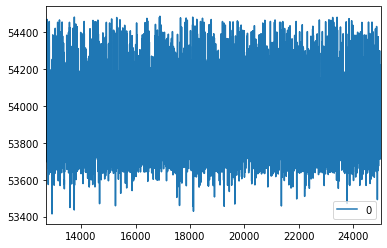

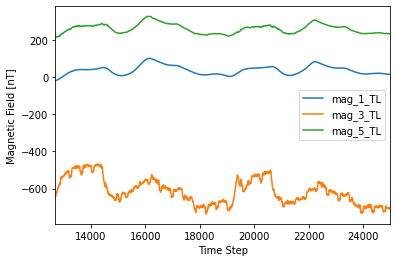

In [95]:
from scipy.signal import detrend
plt.figure(figsize=(16,12))
predictions[12701:25001].plot()
mags_TL[12701:25001].plot()
#plt.plot(detrend(predictions[12701:25001]))
plt.xlabel("Time Step")
plt.ylabel("Magnetic Field [nT]")
plt.show()